In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
from healpy.newvisufunc import projview
import itertools as it
import fitsio
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u
import time
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools
import ellisbaldwin
from qso_sample import QSOSample
import dipole

### compare regularization: `Wmask` vs. `Lambda`

We have the usual linear least-squares fit
$$
\Theta = [\, A^T\, C^{-1}\, A\, ]^{-1}[\, A^T\, C^{-1}\, Y\, ]
$$

`Wmask`: Set all masked values (healpixels) to 0 in $Y$ and to $W_\mathrm{mask}$ in $C^{-1}$

`Lambda`: The fit becomes
$$
\Theta = [\, A^T\, C^{-1}\, A\, + \Lambda I]^{-1}[\, A^T\, C^{-1}\, Y\, ]
$$
where $\Lambda$ is a scalar (like $W_\mathrm{mask}$) and $I$ is the identity matrix.

In [3]:
# instantiate dipole object:
catdir = '/scratch/aew492/quasars/catalogs'
mask_fn = os.path.join(catdir, 'masks/mask_master_hpx_r1.0.fits')

d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
              mask_fn=mask_fn,
              mag='g', maglim=20.,
              blim=15)
d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table

# get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                            min_g=19.5, max_g=20.5)
d.cut_mag()  # now we cut all sources fainter than the input magnitude limit

# at the healpix level:

# load selection function
selfunc_quaia = d.get_selfunc(os.path.join(catdir, 'quaia/selfuncs',
                                            f'selection_function_NSIDE{d.NSIDE}_G{d.maglim}_blim15.fits')) # note the blim15 !
# overdensity map, corrected by selection function
overdensity_map = d.construct_overdensity_map(selfunc=selfunc_quaia, min_completeness=0.)

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 15 -> 1227794 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.304
	effective alpha = 0.744
	expected dipole amplitude = 0.0053
cut G > 20.0 -> 711896 sources left.
constructing overdensity map
defining healpix mask...
	masked pixels |b|<15deg, from mask_fn, and where completeness < 0.0


In [4]:
# a few different regularization values
Wmasks = np.logspace(-4, 4, 17)
Lambdas = Wmasks.copy()

In [5]:
# map to fit: set masked pixels to 0
map_to_fit = overdensity_map.copy()
idx_masked = np.isnan(map_to_fit)
map_to_fit[idx_masked] = 0.

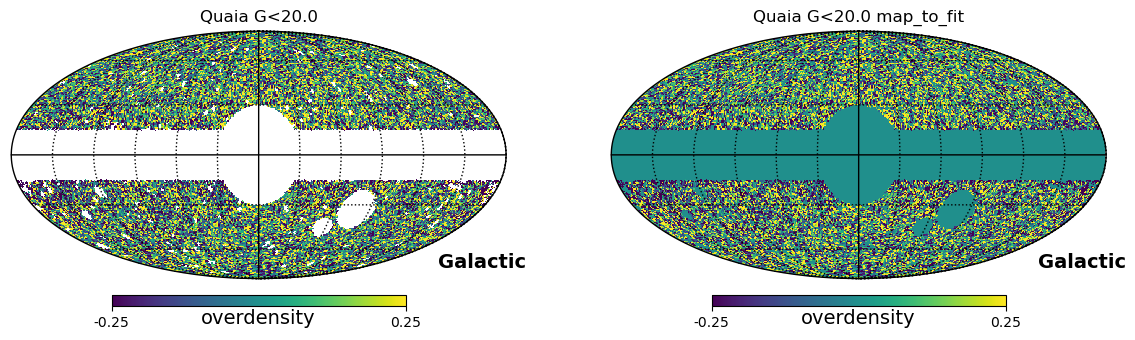

In [6]:
# plot
fig = plt.figure(figsize=(12,3))
hp.mollview(overdensity_map, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,2,1),
            unit='overdensity', title=f'Quaia G<{d.maglim}')
hp.mollview(map_to_fit, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,2,2),
            unit='overdensity', title=f'Quaia G<{d.maglim} map_to_fit')
hp.graticule()

In [7]:
# ^^confirming that `map_to_fit` is the Quaia overdensity map with masked (NaN) pixels set to zero.

#### measure dipole

In [8]:
# no regularization / Secrest's fit
comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=selfunc_quaia, fit_zeros=False)
amp_noreg = np.linalg.norm(comps[1:])

In [9]:
# covariance matrices:
# Lambda method: Cinv is the completeness in each pixel
# Wmask method: completeness in each _data_ pixel, and Wmask in the masked pixels
Cinv_Wmask = selfunc_quaia.copy()
# (need to assign Wmask in the for loop below)

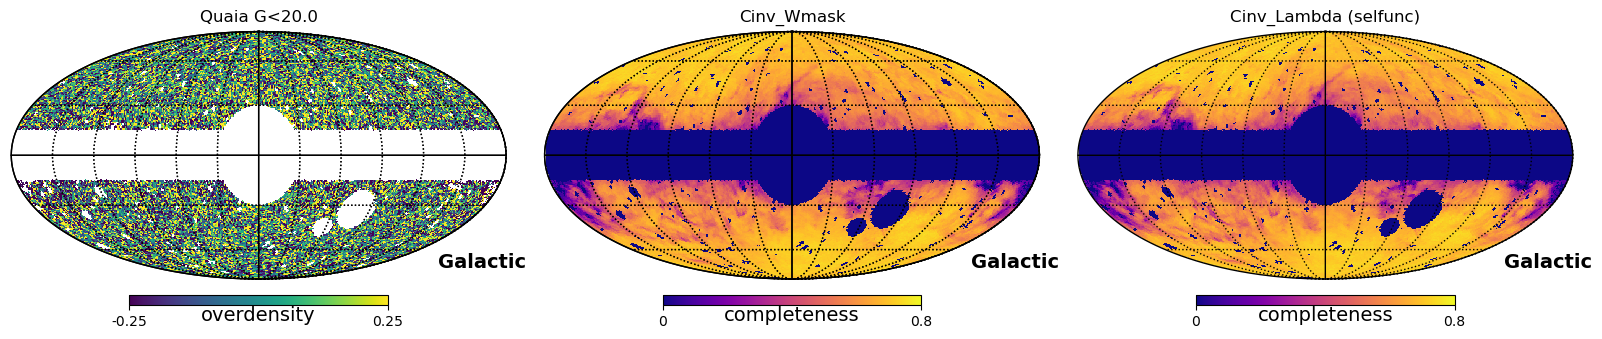

In [10]:
# fit the dipole components
comps_Wmasks = np.empty((len(Wmasks),3))
amps_Wmasks = np.empty(len(Wmasks))
comps_Lambdas = np.empty_like(comps_Wmasks)
amps_Lambdas = np.empty_like(amps_Wmasks)
for i in range(len(Wmasks)):
    Cinv_Wmask[idx_masked] = Wmasks[i]
    comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_Wmask, fit_zeros=True, Lambda=0)
    comps_Wmasks[i] = comps[1:]
    amps_Wmasks[i] = np.linalg.norm(comps[1:])
    comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=selfunc_quaia, fit_zeros=True, Lambda=Lambdas[i])
    comps_Lambdas[i] = comps[1:]
    amps_Lambdas[i] = np.linalg.norm(comps[1:])
    if i==0:
        fig = plt.figure(figsize=(16,3))
        hp.mollview(overdensity_map, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
                    unit='overdensity', title=f'Quaia G<{d.maglim}')
        hp.mollview(Cinv_Wmask, coord=['C','G'], min=0, max=0.8, badcolor='w', fig=fig, sub=(1,3,2),
            unit='completeness', title=f'Cinv_Wmask', cmap='plasma')
        hp.graticule()
        hp.mollview(selfunc_quaia, coord=['C','G'], min=0, max=0.8, badcolor='w', fig=fig, sub=(1,3,3),
            unit='completeness', title=f'Cinv_Lambda (selfunc)', cmap='plasma')
        hp.graticule()

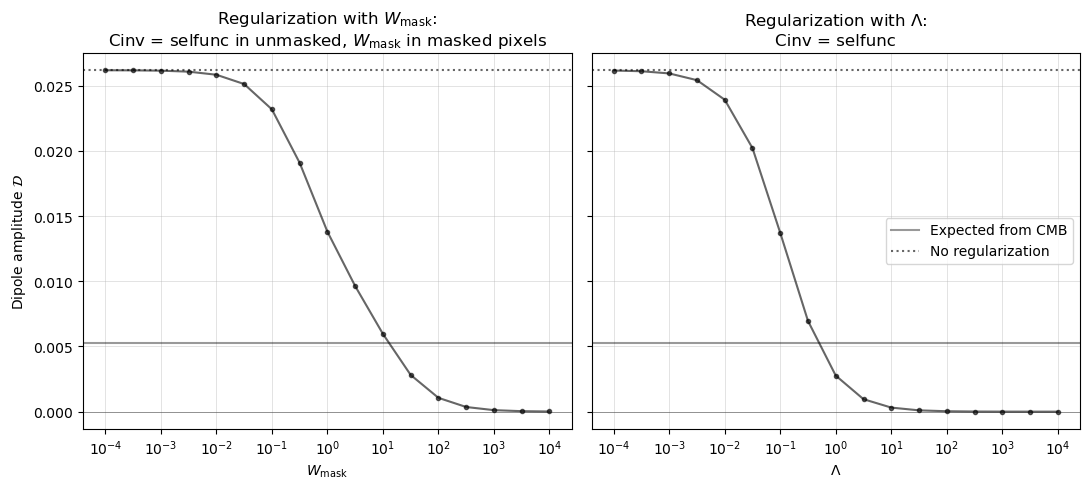

In [11]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,5), tight_layout=True)

for ax in [ax0, ax1]:
    ax.axhline(expected_dipamp_quaia, c='k', lw=1.5, alpha=0.4, label='Expected from CMB')
    ax.axhline(amp_noreg, c='k', lw=1.5, alpha=0.6, ls=':', label='No regularization')
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.grid(alpha=0.5, lw=0.5)
    ax.semilogx()
    ax.set_xticks(np.logspace(-4, 4, 9))
    
ax0.plot(Wmasks, amps_Wmasks, marker='.', c='k', alpha=0.6)
ax0.set_title(r'Regularization with $W_\mathrm{mask}$:'f'\n' +
              # r'$\Theta=[\,A^T\,C^{-1}\,A\,]^{-1}\,[\,A^T\,C^{-1}\,Y\,]$'f'\n' +
              r'Cinv = selfunc in unmasked, $W_\mathrm{mask}$ in masked pixels')
ax0.set_xlabel(r'$W_\mathrm{mask}$')
ax1.plot(Lambdas, amps_Lambdas, marker='.', c='k', alpha=0.6)
ax1.set_title(r'Regularization with $\Lambda$:'f'\n' +
              # r'$\Theta=[\,A^T\,C^{-1}\,A\,+\Lambda\,I\,]^{-1}\,[\,A^T\,C^{-1}\,Y\,]$'f'\n' +
              r'Cinv = selfunc')
ax1.set_xlabel(r'$\Lambda$')
ax1.set_yticklabels([])
ax0.set_ylabel(r'Dipole amplitude $\mathcal{D}$')
ax1.legend()

In [12]:
# where is the selection function zero, and is this the same as the data mask?
selfunc_mask = (selfunc_quaia==0.)
data_mask = (map_to_fit==0.)
np.sum(selfunc_mask), np.sum(data_mask)

(15608, 15608)

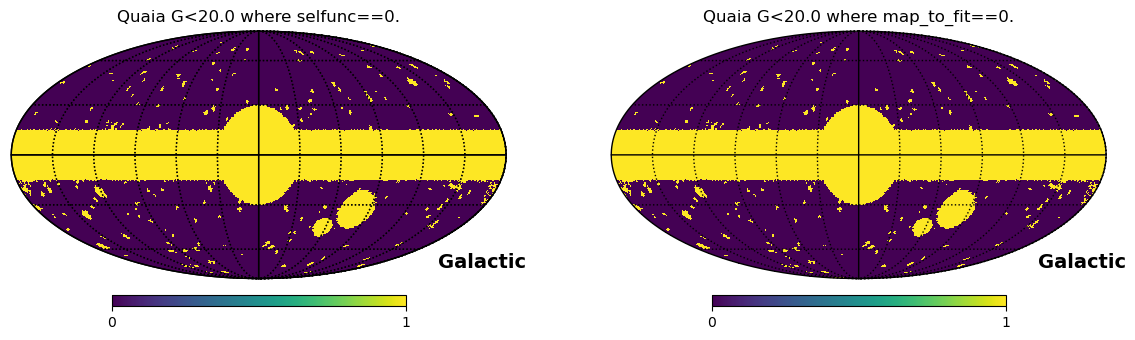

In [13]:
# plot
fig = plt.figure(figsize=(12,3))
hp.mollview(selfunc_mask, coord=['C','G'], badcolor='w', fig=fig, sub=(1,2,1), title=f'Quaia G<{d.maglim} where selfunc==0.')
hp.graticule()
hp.mollview(data_mask, coord=['C','G'], badcolor='w', fig=fig, sub=(1,2,2), title=f'Quaia G<{d.maglim} where map_to_fit==0.')
hp.graticule()

### compare galactic plane cuts -> masked pixels

loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 15 -> 1227794 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.304
	effective alpha = 0.744
	expected dipole amplitude = 0.0053
cut G > 20.0 -> 711896 sources left.
constructing overdensity map
defining healpix mask...
	masked pixels |b|<15deg, from mask_fn, and where completeness < 0.0
loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sources in initial catalog.
cut |b| <= 20 -> 1142086 sources left.
computing expected dipole from Ellis-Baldwin:
	number-count slope x = 1.307
	effective alpha = 0.734
	expected dipole amplitude = 0.0053
cut G > 20.0 -> 660631 sources left.
constructing overdensity map
defining healpix mask...
	masked pixels |b|<20deg, from mask_fn, and where completeness < 0.0
loading initial catalog, /scratch/aew492/quasars/catalogs/quaia/quaia_G20.5.fits
1295502 sourc

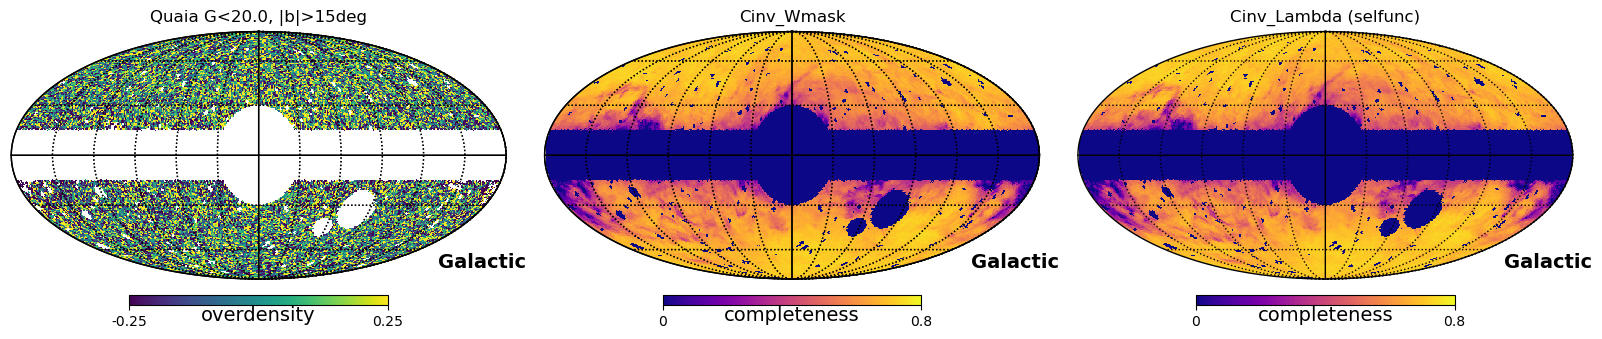

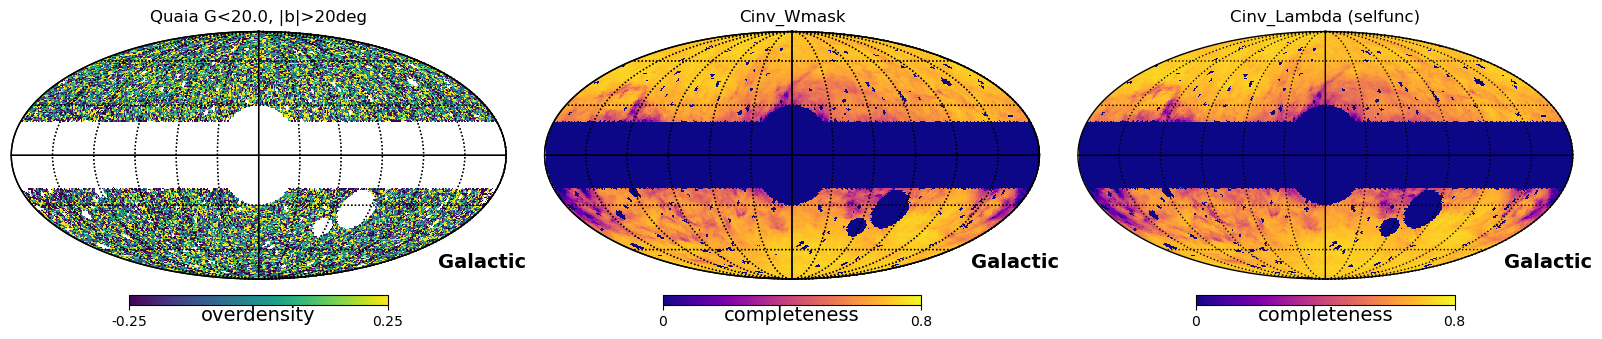

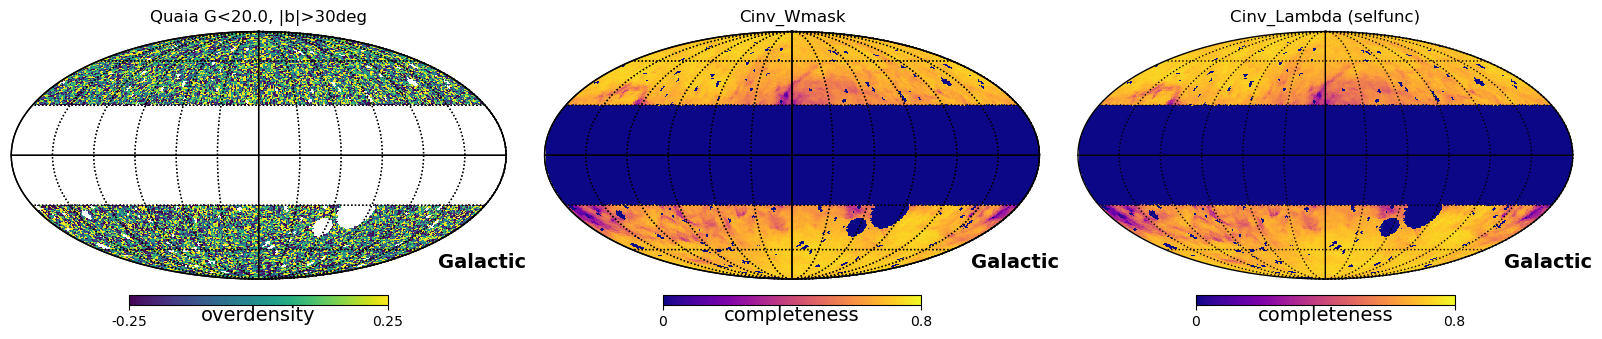

In [16]:
# galactic plane cuts to test
blims = [15,20,30]

# fit the dipole components
amps_noreg = np.empty(len(blims))
amps_Wmasks = np.empty((len(blims), len(Wmasks)))
amps_Lambdas = np.empty_like(amps_Wmasks)
for j, blim in enumerate(blims):
    # map to fit
    # instantiate dipole object:
    #  *catdir, mask_fn, and selfunc_quaia need to be defined above
    d = QSOSample(initial_catfn=os.path.join(catdir, 'quaia/quaia_G20.5.fits'),
                  mask_fn=mask_fn,
                  mag='g', maglim=20.,
                  blim=blim)
    d.cut_galactic_plane()  # cuts all sources with |b|<blim from the working source table
    # get the expected dipole amplitude (before we make the magnitude cut at maglim, so we can compute the number-count slope)
    expected_dipamp_quaia = ellisbaldwin.compute_expected_dipole_gaia(d.table, maglimit=d.maglim,
                                                                min_g=19.5, max_g=20.5)
    d.cut_mag()  # now we cut all sources fainter than the input magnitude limit
    # overdensity map: set minimum completeness to zero
    overdensity_map = d.construct_overdensity_map(selfunc=selfunc_quaia, min_completeness=0.)
    # map to fit: set masked pixels to 0
    map_to_fit = overdensity_map.copy()
    idx_masked = np.isnan(map_to_fit)
    map_to_fit[idx_masked] = 0.

    # no regularization
    comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=selfunc_quaia, fit_zeros=False)
    amps_noreg[j] = np.linalg.norm(comps[1:])

    # regularization: loop through values
    Cinv_Wmask = selfunc_quaia.copy()
    for i in range(len(Wmasks)):
        Cinv_Wmask[idx_masked] = Wmasks[i]
        comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_Wmask, fit_zeros=True, Lambda=0)
        amps_Wmasks[j,i] = np.linalg.norm(comps[1:])
        Cinv_Lambda = selfunc_quaia.copy()
        Cinv_Lambda[idx_masked] = 0. # !
        comps, stderr = dipole.fit_dipole(map_to_fit, Cinv=Cinv_Lambda, fit_zeros=True, Lambda=Lambdas[i])
        amps_Lambdas[j,i] = np.linalg.norm(comps[1:])
        if i==0:
            fig = plt.figure(figsize=(16,3))
            hp.mollview(overdensity_map, coord=['C','G'], min=-0.25, max=0.25, badcolor='w', fig=fig, sub=(1,3,1),
                        unit='overdensity', title=f'Quaia G<{d.maglim}, |b|>{blim}deg')
            hp.mollview(Cinv_Wmask, coord=['C','G'], min=0, max=0.8, badcolor='w', fig=fig, sub=(1,3,2),
                unit='completeness', title=f'Cinv_Wmask', cmap='plasma')
            hp.graticule()
            hp.mollview(Cinv_Lambda, coord=['C','G'], min=0, max=0.8, badcolor='w', fig=fig, sub=(1,3,3),
                unit='completeness', title=f'Cinv_Lambda (selfunc)', cmap='plasma')
            hp.graticule()
    del d # ! to clear space before next loop

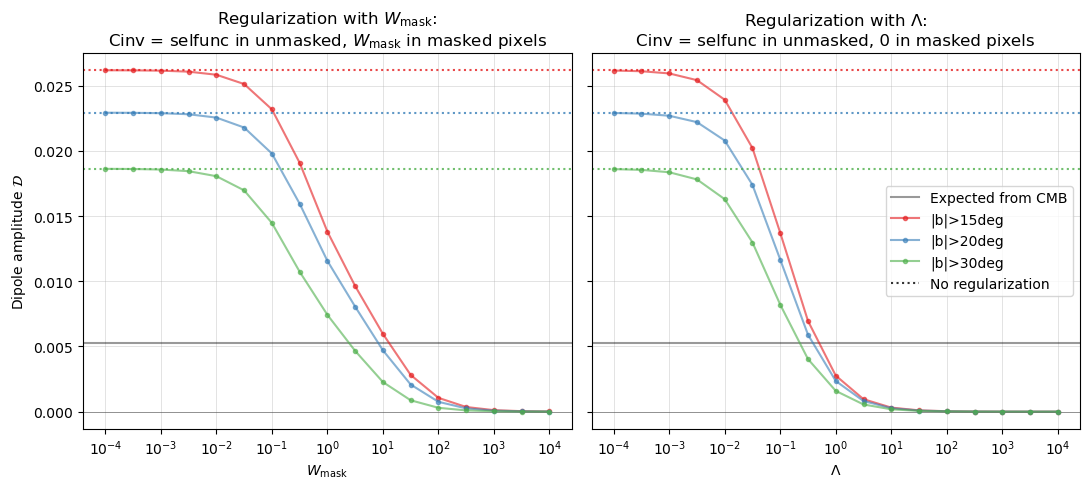

In [18]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11,5), tight_layout=True)
colors = list(map(mpl.cm.Set1, range(len(blims))))
for ax in [ax0, ax1]:
    ax.axhline(expected_dipamp_quaia, c='k', lw=1.5, alpha=0.4, label='Expected from CMB')
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.grid(alpha=0.5, lw=0.5)
    ax.semilogx()
    ax.set_xticks(np.logspace(-4, 4, 9))

for i, blim in enumerate(blims):
    kwargs = dict(marker='.', c=colors[i], alpha=0.6, label=f'|b|>{blim}deg')
    ax0.plot(Wmasks, amps_Wmasks[i], **kwargs)
    ax1.plot(Lambdas, amps_Lambdas[i], **kwargs)
    ax0.axhline(amps_noreg[i], c=colors[i], lw=1.5, alpha=0.8, ls=':')
    ax1.axhline(amps_noreg[i], c=colors[i], lw=1.5, alpha=0.8, ls=':')

label_noreg = mpl.lines.Line2D([0],[0], c='k', alpha=0.8, lw=1.5, ls=':', label='No regularization')

# add manual symbols to auto legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([label_noreg])
    
ax0.set_title(r'Regularization with $W_\mathrm{mask}$:'f'\n' +
              # r'$\Theta=[\,A^T\,C^{-1}\,A\,]^{-1}\,[\,A^T\,C^{-1}\,Y\,]$'f'\n' +
              r'Cinv = selfunc in unmasked, $W_\mathrm{mask}$ in masked pixels')
ax0.set_xlabel(r'$W_\mathrm{mask}$')
ax1.set_title(r'Regularization with $\Lambda$:'f'\n' +
              # r'$\Theta=[\,A^T\,C^{-1}\,A\,+\Lambda\,I\,]^{-1}\,[\,A^T\,C^{-1}\,Y\,]$'f'\n' +
              r'Cinv = selfunc in unmasked, 0 in masked pixels')
ax1.set_xlabel(r'$\Lambda$')
ax1.set_yticklabels([])
ax0.set_ylabel(r'Dipole amplitude $\mathcal{D}$')
ax1.legend(handles=handles)